In [55]:
import pandas
import numpy
from matplotlib import pyplot
import os
import ROOT

In [56]:
times = {"cores":[],"mean":[],"meanerr":[],"throughput_GB_s":[]}
timedir = "singlenode-20211108/appruntimes"
datasetsize = 157400503680
readpercent = 0.7949011466389114
readsize = datasetsize * readpercent

for f in os.listdir(timedir):
    array = numpy.genfromtxt(timedir+"/"+f, skip_header=1)
    nodes = f.split("_")[5].replace("cores.csv","")
    time_mean = numpy.mean(array)
    times["cores"].append(int(nodes))
    times["mean"].append(round(time_mean, 2))
    times["meanerr"].append(round(numpy.std(array)/numpy.sqrt(len(array)), 2))
    times["throughput_GB_s"].append(readsize/time_mean/pow(10, 9))
    
timesdf = pandas.DataFrame(times)
timesdf = timesdf.sort_values(by="cores").reset_index(drop=True).copy()
timesdf

,cores,mean,meanerr,throughput_GB_s
0,1,160.17,2.56,0.781172
1,2,86.00,1.92,1.454930
2,4,47.26,0.51,2.647617
3,6,33.89,0.60,3.692111
4,8,27.07,0.35,4.621973
5,10,23.24,0.61,5.384423
6,12,22.52,0.33,5.554649
7,14,22.99,0.23,5.442430
8,16,22.41,0.29,5.584039


In [57]:
throughput_1node = timesdf["throughput_GB_s"][0]
timesdf["throughputspeedup"] = timesdf["throughput_GB_s"] / throughput_1node
timesdf

,cores,mean,meanerr,throughput_GB_s,throughputspeedup
0,1,160.17,2.56,0.781172,1.000000
1,2,86.00,1.92,1.454930,1.862497
2,4,47.26,0.51,2.647617,3.389289
3,6,33.89,0.60,3.692111,4.726376
4,8,27.07,0.35,4.621973,5.916719
5,10,23.24,0.61,5.384423,6.892752
6,12,22.52,0.33,5.554649,7.110663
7,14,22.99,0.23,5.442430,6.967009
8,16,22.41,0.29,5.584039,7.148286


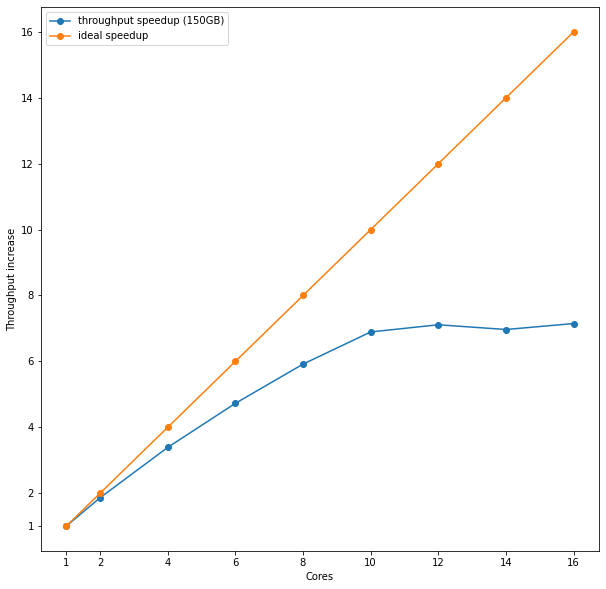

In [58]:
pyplot.figure(figsize=[10,10])
pyplot.plot(timesdf["cores"], timesdf["throughputspeedup"], label="throughput speedup (150GB)", marker="o")
pyplot.plot(timesdf["cores"], timesdf["cores"], label="ideal speedup", marker="o")
pyplot.xticks(timesdf["cores"])
pyplot.yticks(timesdf["cores"])
pyplot.xlabel("Cores")
pyplot.ylabel("Throughput increase")
pyplot.legend()

No handles with labels found to put in legend.


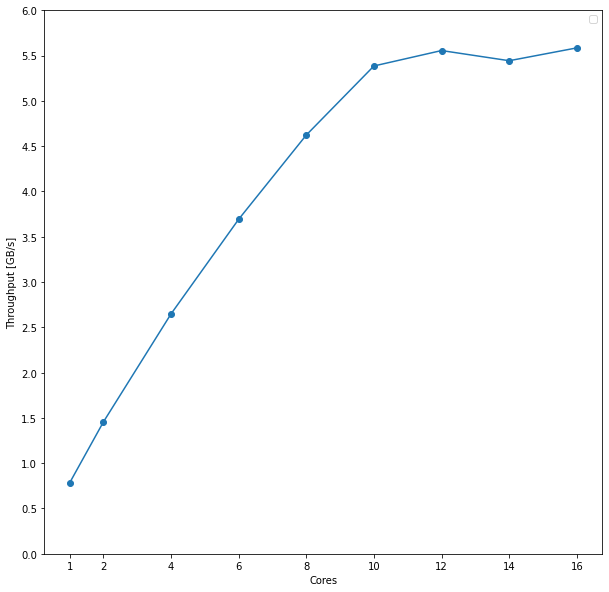

In [59]:
pyplot.figure(figsize=[10,10])
pyplot.plot(timesdf["cores"], timesdf["throughput_GB_s"], marker="o")
pyplot.xticks(timesdf["cores"])

pyplot.xlabel("Cores")
pyplot.ylabel("Throughput [GB/s]")
pyplot.yticks(numpy.linspace(0,6,13))
pyplot.legend()

# RNTuple read throughput

In [60]:
times = {"taskid":[],"mean":[],"meanerr":[],"throughput_MB_s":[]}
maindir = "singlenode-20211108"
timedirs = [timedir for timedir in os.listdir(maindir) if timedir.startswith("timeresults")]

dfs = []
for timedir in timedirs:
    nodes = timedir.split("_")[2].replace("cores","")
    chunks = nodes
    for f in os.listdir(os.path.join(maindir, timedir)):
        df = pandas.read_csv(os.path.join(maindir, timedir, f), header=None, names=["taskruntime","taskreadtime","readthroughput","readpayload"], skiprows=1)
        taskid = f.split("_")[1].replace("task","")
        df["taskid"] = int(taskid)
        df["cores"] = int(nodes)
        dfs.append(df)

df = pandas.concat(dfs).sort_values(by="cores").reset_index(drop=True)
df

,taskruntime,taskreadtime,readthroughput,readpayload,taskid,cores
0,168.267,34866821078,3239,112940757600,0,1
1,151.682,30863344592,3659,112940757600,0,1
2,154.331,30844135161,3661,112940757600,0,1
3,157.062,31119303035,3629,112940757600,0,1
4,152.818,31087372017,3633,112940757600,0,1
...,...,...,...,...,...,...
652,22.473,21738513903,324,7058797416,7,16
653,21.728,20257590497,348,7058797416,7,16
654,23.581,21748762351,324,7058797416,7,16
655,21.479,20298239691,347,7058797416,11,16


In [61]:
meantaskthroughput = df.groupby(["cores"]).mean()[["taskruntime","taskreadtime","readthroughput","readpayload"]]
meantaskthroughput = meantaskthroughput.reset_index().sort_values("cores").reset_index(drop=True)
meantaskthroughput["taskreadtime_s"] = meantaskthroughput["taskreadtime"] / 1000000000
meantaskthroughput

,cores,taskruntime,taskreadtime,readthroughput,readpayload,taskreadtime_s
0,1,160.061000,3.084338e+10,3678.000000,1.129408e+11,30.843375
1,2,82.819111,1.584487e+10,3582.833333,5.647038e+10,15.844872
2,4,45.024333,1.059426e+10,2733.027778,2.823519e+10,10.594258
3,6,31.395167,9.586011e+09,2039.851852,1.882346e+10,9.586011
4,8,24.468236,9.560756e+09,1547.250000,1.411759e+10,9.560756
5,10,21.692800,1.371722e+10,890.311111,1.129408e+10,13.717220
6,12,21.404259,1.882208e+10,505.518519,9.411730e+09,18.822080
7,14,22.225222,2.068847e+10,390.301587,8.067197e+09,20.688469
8,16,21.675715,2.052270e+10,344.236111,7.058797e+09,20.522698


Text(0, 0.5, 'Throughput [MB/s]')

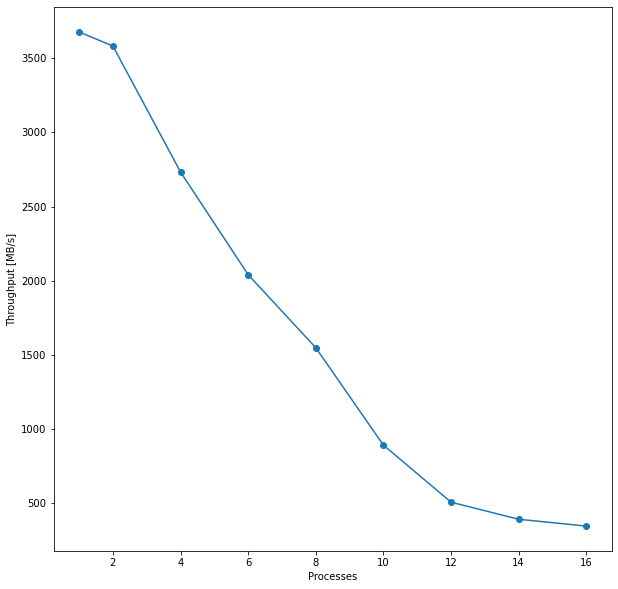

In [62]:
pyplot.figure(figsize=[10,10])
pyplot.plot(meantaskthroughput["cores"], meantaskthroughput["readthroughput"], marker="o")
pyplot.xlabel("Processes")
pyplot.ylabel("Throughput [MB/s]")

Text(0, 0.5, 'Time [s]')

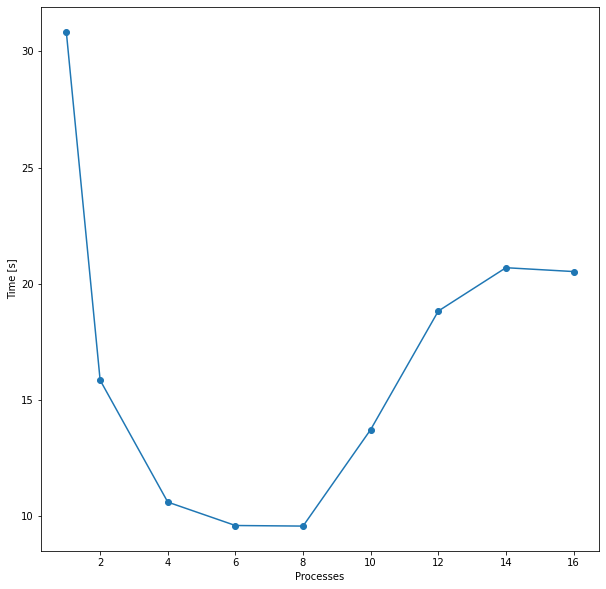

In [63]:
pyplot.figure(figsize=[10,10])
pyplot.plot(meantaskthroughput["cores"], meantaskthroughput["taskreadtime_s"], marker="o")
pyplot.xlabel("Processes")
pyplot.ylabel("Time [s]")

In [64]:
sumthroughput = df.groupby(["cores","taskid"]).mean()
sumthroughput = sumthroughput.reset_index().groupby(["cores"]).sum()
sumthroughput = sumthroughput.reset_index()
sumthroughput["totalthroughput"] = sumthroughput["readthroughput"] / 1024
sumthroughput

,cores,taskid,taskruntime,taskreadtime,readthroughput,readpayload,totalthroughput
0,1,0,160.061000,3.084338e+10,3678.000000,1.129408e+11,3.591797
1,2,1,165.638222,3.168974e+10,7165.666667,1.129408e+11,6.997721
2,4,6,180.097333,4.237703e+10,10932.111111,1.129408e+11,10.675890
3,6,15,188.371000,5.751607e+10,12239.111111,1.129408e+11,11.952257
4,8,28,195.745889,7.648605e+10,12378.000000,1.129408e+11,12.087891
5,10,45,216.928000,1.371722e+11,8903.111111,1.129408e+11,8.694444
6,12,66,256.851111,2.258650e+11,6066.222222,1.129408e+11,5.924045
7,14,91,311.153111,2.896386e+11,5464.222222,1.129408e+11,5.336155
8,16,120,346.811444,3.283632e+11,5507.777778,1.129408e+11,5.378689


Text(0, 0.5, 'Throughput [GB/s]')

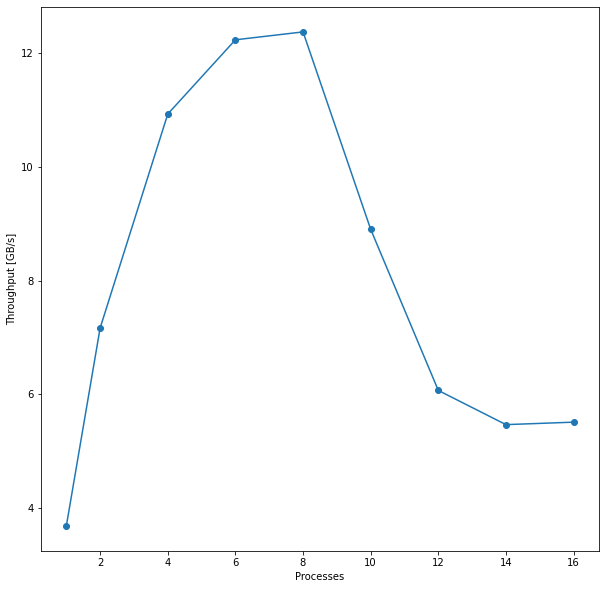

In [65]:
pyplot.figure(figsize=[10,10])
pyplot.plot(sumthroughput["cores"], sumthroughput["readthroughput"]/1000, marker="o")
pyplot.xlabel("Processes")
pyplot.ylabel("Throughput [GB/s]")

Text(0, 0.5, 'Readtime [ns]')

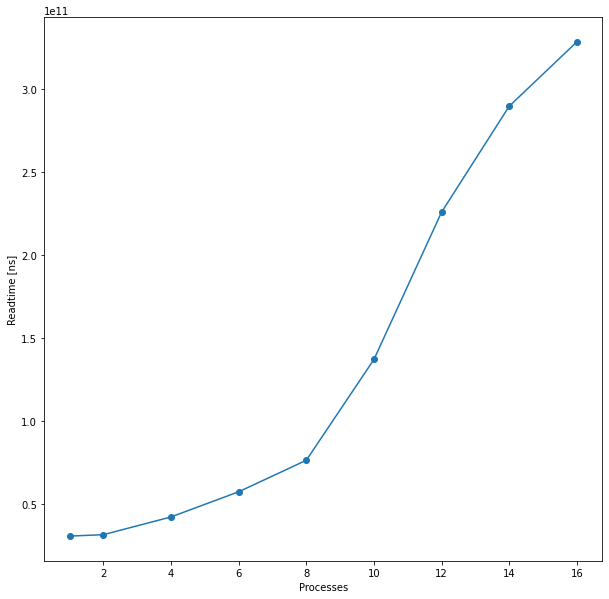

In [66]:
pyplot.figure(figsize=[10,10])
pyplot.plot(sumthroughput["cores"], sumthroughput["taskreadtime"], marker="o")
pyplot.xlabel("Processes")
pyplot.ylabel("Readtime [ns]")

# TGraph

Warning in <TCanvas::Constructor>: Deleting canvas with same name: d
Info in <TCanvas::Print>: png file distrdf_lhcb_singlenode_processingthroughput.png has been created


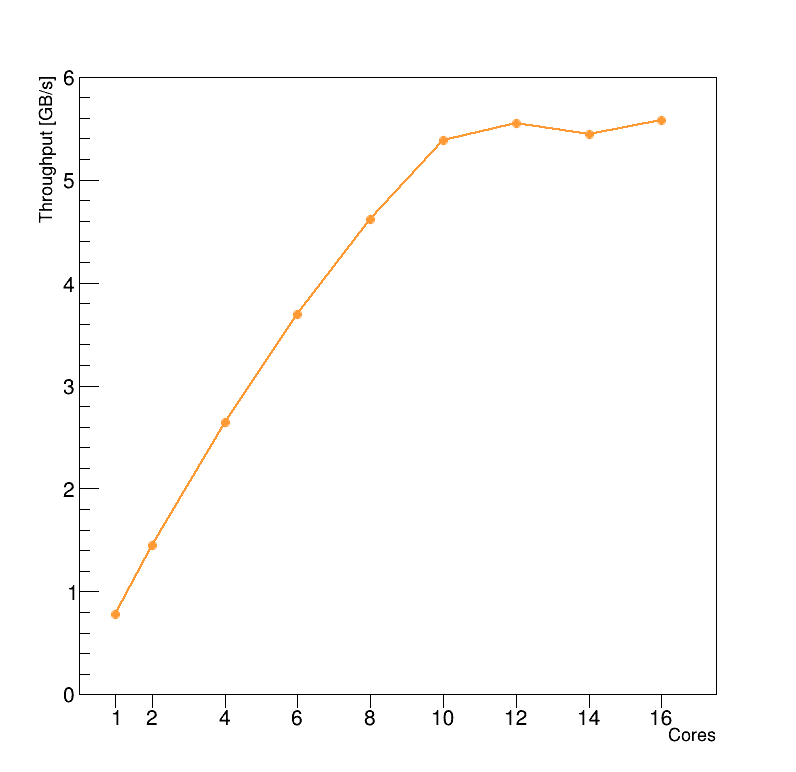

In [72]:
runtimegraph = ROOT.TGraph(len(timesdf["cores"]), numpy.array(timesdf["cores"], dtype=float), numpy.array(timesdf["throughput_GB_s"], dtype=float))

width = 800
height = 800
d = ROOT.TCanvas("d", "", width, height)

runtimegraph.SetTitle("")

runtimegraph.GetXaxis().SetTitle("Cores")
runtimegraph.GetXaxis().SetTitleSize(0.025)
runtimegraph.GetXaxis().SetTitleOffset(1.3)
runtimegraph.GetXaxis().SetLabelSize(0)
runtimegraph.GetXaxis().SetTickLength(0)

runtimegraph.GetYaxis().SetTitle("Throughput [GB/s]")
runtimegraph.GetYaxis().SetLabelSize(0.03)
runtimegraph.GetYaxis().SetTitleSize(0.025)
runtimegraph.GetYaxis().SetRangeUser(0, 6)

runtimegraph.SetMarkerStyle(20)
runtimegraph.SetMarkerSize(1)
runtimegraph.SetMarkerColor(ROOT.kOrange+1)

runtimegraph.SetLineStyle(ROOT.kSolid)
# Line color also decides error bar color somehow
runtimegraph.SetLineColorAlpha(ROOT.kOrange+1,1)
runtimegraph.SetLineWidth(2)
runtimegraph.Draw("APL")

ymin = runtimegraph.GetHistogram().GetMinimum()
ymax = runtimegraph.GetHistogram().GetMaximum()

dy = ymax - ymin
labels = []
ticks = []

for i in range(len(timesdf["cores"])):
    x = runtimegraph.GetPointX(i)
    t = ROOT.TLatex(x, ymin - 0.05 * dy, str(int(x)))
    t.SetTextSize(0.03)
    t.SetTextFont(42)
    t.SetTextAlign(21)
    t.Draw()
    labels.append(t)
    l = ROOT.TLine(x, ymin, x,ymin-0.02*dy)
    l.Draw()
    ticks.append(l)
    
d.Draw()
d.SaveAs("distrdf_lhcb_singlenode_processingthroughput.png")

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file distrdf_lhcb_singlenode_processingthroughputspeedup.png has been created


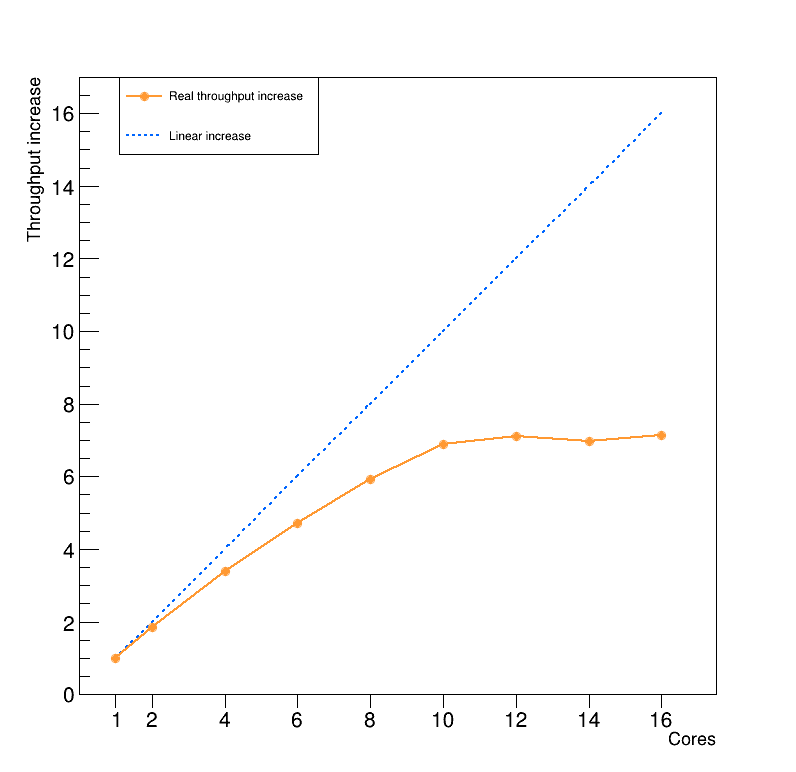

In [75]:
speedupgraph = ROOT.TGraph(len(timesdf["cores"]), numpy.array(timesdf["cores"], dtype=float), numpy.array(timesdf["throughputspeedup"], dtype=float))
idealspeedupgraph = ROOT.TGraph(len(timesdf["cores"]), numpy.array(timesdf["cores"], dtype=float), numpy.array(timesdf["cores"], dtype=float))

width = 800
height = 800
c = ROOT.TCanvas("c", "", width, height)

idealspeedupgraph.SetTitle("")

idealspeedupgraph.GetXaxis().SetTitle("Cores")
idealspeedupgraph.GetXaxis().SetTitleSize(0.025)
idealspeedupgraph.GetXaxis().SetTitleOffset(1.4)
idealspeedupgraph.GetXaxis().SetLabelSize(0)
idealspeedupgraph.GetXaxis().SetTickLength(0)
idealspeedupgraph.GetYaxis().SetTitle("Throughput increase")

idealspeedupgraph.GetYaxis().SetTitleSize(0.025)
idealspeedupgraph.GetYaxis().SetTitleOffset(1.4)
idealspeedupgraph.GetYaxis().SetRangeUser(0, 17)
idealspeedupgraph.GetYaxis().SetLabelSize(0.03)

idealspeedupgraph.SetMarkerColor(ROOT.kAzure-3)
idealspeedupgraph.SetMarkerSize(1)
idealspeedupgraph.SetMarkerStyle(20)
idealspeedupgraph.SetLineStyle(ROOT.kDashed)
idealspeedupgraph.SetLineColorAlpha(ROOT.kAzure-3,1)
idealspeedupgraph.SetLineWidth(2)
idealspeedupgraph.Draw("AL")

ymin = idealspeedupgraph.GetHistogram().GetMinimum()
ymax = idealspeedupgraph.GetHistogram().GetMaximum()

dy = ymax - ymin
xlabels = []
xticks = []
#ylabels = []
#yticks = []

for i in range(len(timesdf["cores"])):
    x = idealspeedupgraph.GetPointX(i)
    y = idealspeedupgraph.GetPointY(i)

    xt = ROOT.TLatex(x, -0.9, str(int(x)))
    xt.SetTextSize(0.03)
    xt.SetTextFont(42)
    xt.SetTextAlign(21)
    xt.Draw()
    xlabels.append(xt)

    xl = ROOT.TLine(x, ymin, x,ymin-0.02*dy)
    xl.Draw()
    xticks.append(xl)

speedupgraph.SetMarkerStyle(20)
speedupgraph.SetMarkerSize(1)
speedupgraph.SetMarkerColor(ROOT.kOrange+1)


speedupgraph.SetLineColorAlpha(ROOT.kOrange+1,1)
speedupgraph.SetLineWidth(2)

speedupgraph.Draw("SAME PL")

legend = ROOT.TLegend(0.15,0.8,0.4,0.9)
legend.AddEntry(speedupgraph, "Real throughput increase")
legend.AddEntry(idealspeedupgraph, "Linear increase", "L")
legend.Draw()

c.Draw()
c.SaveAs("distrdf_lhcb_singlenode_processingthroughputspeedup.png")

Warning in <TCanvas::Constructor>: Deleting canvas with same name: d
Info in <TCanvas::Print>: png file distrdf_lhcb_singlenode_readthroughput.png has been created


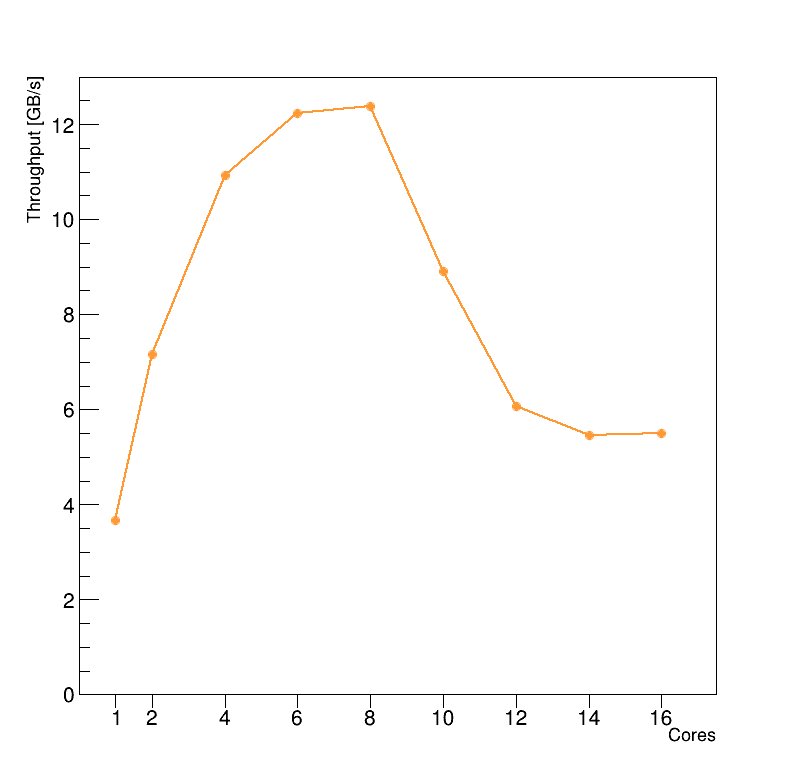

In [74]:
runtimegraph = ROOT.TGraph(len(sumthroughput["cores"]), numpy.array(sumthroughput["cores"], dtype=float), numpy.array(sumthroughput["readthroughput"]/1000, dtype=float))

width = 800
height = 800
d = ROOT.TCanvas("d", "", width, height)

runtimegraph.SetTitle("")

runtimegraph.GetXaxis().SetTitle("Cores")
runtimegraph.GetXaxis().SetTitleSize(0.025)
runtimegraph.GetXaxis().SetTitleOffset(1.3)
runtimegraph.GetXaxis().SetLabelSize(0)
runtimegraph.GetXaxis().SetTickLength(0)

runtimegraph.GetYaxis().SetTitle("Throughput [GB/s]")
runtimegraph.GetYaxis().SetLabelSize(0.03)
runtimegraph.GetYaxis().SetTitleSize(0.025)
runtimegraph.GetYaxis().SetRangeUser(0, 13)

runtimegraph.SetMarkerStyle(20)
runtimegraph.SetMarkerSize(1)
runtimegraph.SetMarkerColor(ROOT.kOrange+1)

runtimegraph.SetLineStyle(ROOT.kSolid)
# Line color also decides error bar color somehow
runtimegraph.SetLineColorAlpha(ROOT.kOrange+1,1)
runtimegraph.SetLineWidth(2)
runtimegraph.Draw("APL")

ymin = runtimegraph.GetHistogram().GetMinimum()
ymax = runtimegraph.GetHistogram().GetMaximum()

dy = ymax - ymin
labels = []
ticks = []

for i in range(len(sumthroughput["cores"])):
    x = runtimegraph.GetPointX(i)
    t = ROOT.TLatex(x, ymin - 0.05 * dy, str(int(x)))
    t.SetTextSize(0.03)
    t.SetTextFont(42)
    t.SetTextAlign(21)
    t.Draw()
    labels.append(t)
    l = ROOT.TLine(x, ymin, x,ymin-0.02*dy)
    l.Draw()
    ticks.append(l)
    
d.Draw()
d.SaveAs("distrdf_lhcb_singlenode_readthroughput.png")